In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('../..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)
import electronTransportCode.exactSolution
%matplotlib widget

In [2]:
eSource, scatteringRate1, NB_PARTICLES, dsArray, repeats = pickle.load(open('data/simargv.pkl', 'rb'))
bins = 500
nbdS = dsArray.size
binRange = (-5.0, 5.0)

# Load analog estimators
analogTEE = np.empty((repeats, bins), dtype=float)
for repeat in range(repeats):
    TEE = pickle.load(open(f'data/TEEAnalog_{repeat}.pkl', 'rb'))[0]
    binCenter, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
    analogTEE[repeat, :] = binVal

# Load KDMC estimators
KDMCTEE = np.empty((nbdS, repeats, bins), dtype=float)
for i in range(nbdS):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEKDMC{i}_{repeat}.pkl', 'rb'))[0]
        _, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
        KDMCTEE[i, repeat, :] = binVal

# Load KDSMC estimators
KDSMCTEE = np.empty((nbdS, repeats, bins), dtype=float)
for i in range(nbdS):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEKDSMC{i}_{repeat}.pkl', 'rb'))[0]
        _, binVal = TEE.getDensityData(bins=bins, binRange=binRange)
        KDSMCTEE[i, repeat, :] = binVal

print(f'{eSource=}')
print(f'{NB_PARTICLES=}')
print(f'{repeats=}')

eSource=5.0
NB_PARTICLES=500000
repeats=10


In [3]:
# Compute exact solution 

resy = np.zeros_like(binCenter)
for index, r in enumerate(binCenter):
    resy[index] = electronTransportCode.exactSolution.planeSourceSolution(r, 0.0, eSource, sigma=scatteringRate1)

# Normalize
resy = resy/np.trapz(resy, binCenter)  

$\Delta s = 4.41e-02$
$\Delta s = 1.94e+00$


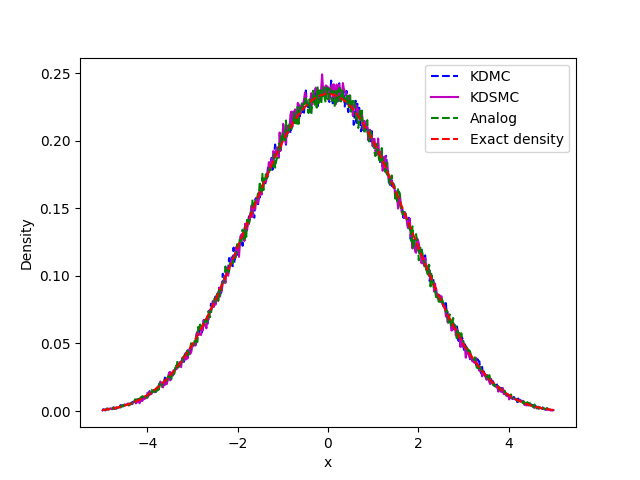

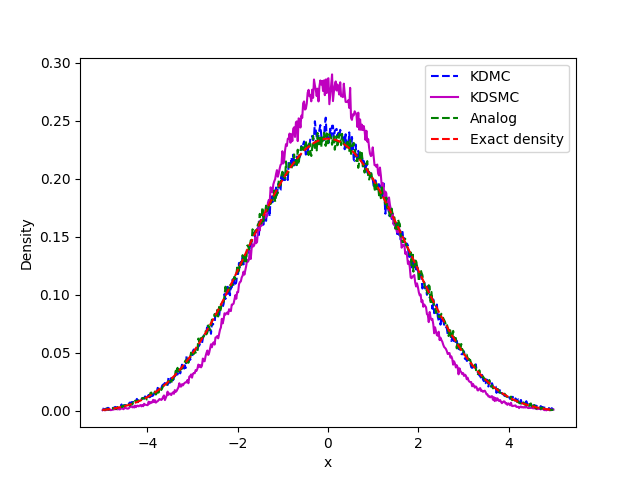

In [7]:
fig1, ax1 = plt.subplots()
index1 = 4

ax1.plot(binCenter, KDMCTEE[index1, 0, :], '--b', label=f'KDMC')  
ax1.plot(binCenter, KDSMCTEE[index1, 0, :], '-m', label=f'KDSMC')   
ax1.plot(binCenter, analogTEE[0, :], '--g', label='Analog')
ax1.plot(binCenter, resy, '--r', label='Exact density')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
# ax1.set_title(f'$\Delta s = {dsArray[index1]:.2e}$')
ax1.legend()
fig1.savefig('figures/Density1.pdf', format='pdf')


fig2, ax2 = plt.subplots()
index2 = 8

ax2.plot(binCenter, KDMCTEE[index2, 0, :], '--b', label=f'KDMC')  
ax2.plot(binCenter, KDSMCTEE[index2, 0, :], '-m', label=f'KDSMC')   
ax2.plot(binCenter, analogTEE[0, :], '--g', label='Analog')
ax2.plot(binCenter, resy, '--r', label='Exact density')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
# ax2.set_title(f'$\Delta s = {dsArray[index2]:.2e}$')
ax2.legend()
fig2.savefig('figures/Density2.pdf', format='pdf')

print(f'$\Delta s = {dsArray[index1]:.2e}$')
print(f'$\Delta s = {dsArray[index2]:.2e}$')

In [5]:
# Compute error of distributions
KDMCErr = np.empty(shape=(nbdS, repeats))
KDSMCErr = np.empty(shape=(nbdS, repeats))
analogErr = np.empty(shape=(repeats))
for repeat in range(repeats):
    analogErr[repeat] = stats.wasserstein_distance(resy, analogTEE[repeat, :])
    for i in range(nbdS):
        KDMCErr[i, repeat] = stats.wasserstein_distance(resy, KDMCTEE[i, repeat, :])
        KDSMCErr[i, repeat] = stats.wasserstein_distance(resy, KDSMCTEE[i, repeat, :])

# Average over repeats
KDMCAvgErr = KDMCErr.mean(axis=1)
KDSMCAvgErr = KDSMCErr.mean(axis=1)
analogAvgErr = analogErr.mean()

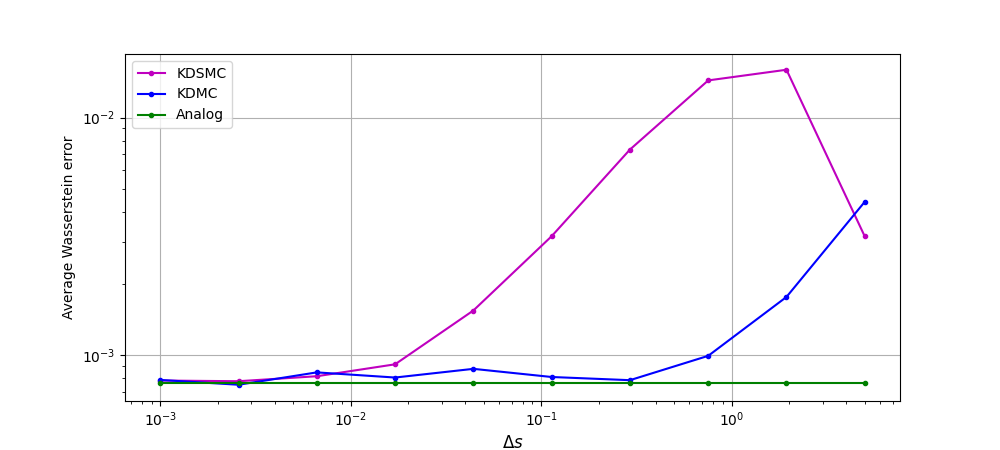

In [6]:
# Plot error
fig, ax1 = plt.subplots(figsize=(10, 4.5))

ax1.loglog(dsArray, KDSMCAvgErr, '.-m', label='KDSMC')
ax1.loglog(dsArray, KDMCAvgErr, '.-b', label='KDMC')
ax1.loglog(dsArray, np.ones_like(dsArray)*analogAvgErr, '.-g', label='Analog')

ax1.set_xlabel('$\Delta s$', fontdict={'fontsize': 12})
ax1.set_ylabel('Average Wasserstein error')
ax1.legend()
ax1.grid()
fig.savefig('figures/pointSourceDS.pdf', format='pdf')

# ax1.set_title(f'Average Wasserstein error over {repeats} runs for {NB_PARTICLES} particles')